# Recommender Systems


Here we'll be implementing a recommender system from scratch using **Singular Value Decomposition** on *MovieLens 1M Dataset*.

**Dimensionality Reduction** is a mathematical technique used to derive the tastes and preferences from the raw data, otherwise known as doing low-rank matrix factorization. Why reduce dimensions?

I can discover hidden correlations / features in the raw data.
I can remove redundant and noisy features that are not useful.
I can interpret and visualize the data easier.
I can also access easier data storage and processing.
With that goal in mind, I'll introduce Singular Vector Decomposition (SVD) to you, a powerful dimensionality reduction technique that is used heavily in modern model-based CF recommender system.

### Loading the Dataset

Let's load the 3 data files

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os

In [2]:
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

#### Exploring the datasets

In [3]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
n_ratings = ratings.shape[0]
print('Number of users = ' + str(n_users) + ' & Number of movies = ' + str(n_movies) + ' in ' + str(n_ratings) + ' Ratings.')

Number of users = 6040 & Number of movies = 3706 in 1000209 Ratings.


Now I want the format of my ratings matrix to be **one row per user** and **one column per movie**. To do so, I'll **pivot** ratings to get that and call the new variable Ratings (with a capital *R).

In [11]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [12]:
R = Ratings.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)


With my ratings matrix properly formatted and normalized, I'm ready to do some dimensionality reduction. But first, let's go over the math.

## Model-Based Collaborative Filtering

*Model-based Collaborative Filtering* is based on *matrix factorization (MF)* which has received greater exposure, mainly as an **unsupervised learning** method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

-  The goal of MF is to **learn the latent preferences of users** and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
-  When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
-  You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which **fills in the entries missing in the original matrix**.


For example, let's check the sparsity of the ratings dataset:

In [8]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 95.5%


## Support Vector Decomposition (SVD)

A well-known matrix factorization method is **Singular value decomposition (SVD)**. At a high level, SVD is an algorithm that decomposes a matrix $A$ into the **best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$**. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix

$A$ = $U$ $\Sigma$ $V^{T}$ 

$A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. 

**$U$ represents how much users "like" each feature** and **$V^{T}$ represents how relevant each feature is to each movie**.

To get the lower rank approximation, I take these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

### Setting Up SVD

In [18]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

As I'm going to leverage matrix multiplication to get predictions, I'll convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [19]:
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices

Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [11]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [12]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [14]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations)) 
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

## In action
This is all what Machine Learning looks like these days.

Once you know what each function/model does, you pass it inputs in required format and get output in required format.

In [15]:
already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 20)

User 1310 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [16]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,genres
5,1310,2248,5,974781573,Say Anything... (1989),Comedy|Drama|Romance
6,1310,2620,5,974781573,This Is My Father (1998),Drama|Romance
7,1310,3683,5,974781935,Blood Simple (1984),Drama|Film-Noir
15,1310,1704,5,974781573,Good Will Hunting (1997),Drama
1,1310,1293,5,974781839,Gandhi (1982),Drama
12,1310,3101,4,974781573,Fatal Attraction (1987),Thriller
11,1310,1343,4,974781534,Cape Fear (1991),Thriller
20,1310,2000,4,974781892,Lethal Weapon (1987),Action|Comedy|Crime|Drama
18,1310,3526,4,974781892,Parenthood (1989),Comedy|Drama
17,1310,3360,4,974781935,Hoosiers (1986),Drama


In [17]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movie_id,title,genres
1618,1674,Witness (1985),Drama|Romance|Thriller
1880,1961,Rain Man (1988),Drama
1187,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1216,1242,Glory (1989),Action|Drama|War
1202,1225,Amadeus (1984),Drama
1273,1302,Field of Dreams (1989),Drama
1220,1246,Dead Poets Society (1989),Drama
1881,1962,Driving Miss Daisy (1989),Drama
1877,1957,Chariots of Fire (1981),Drama
1938,2020,Dangerous Liaisons (1988),Drama|Romance


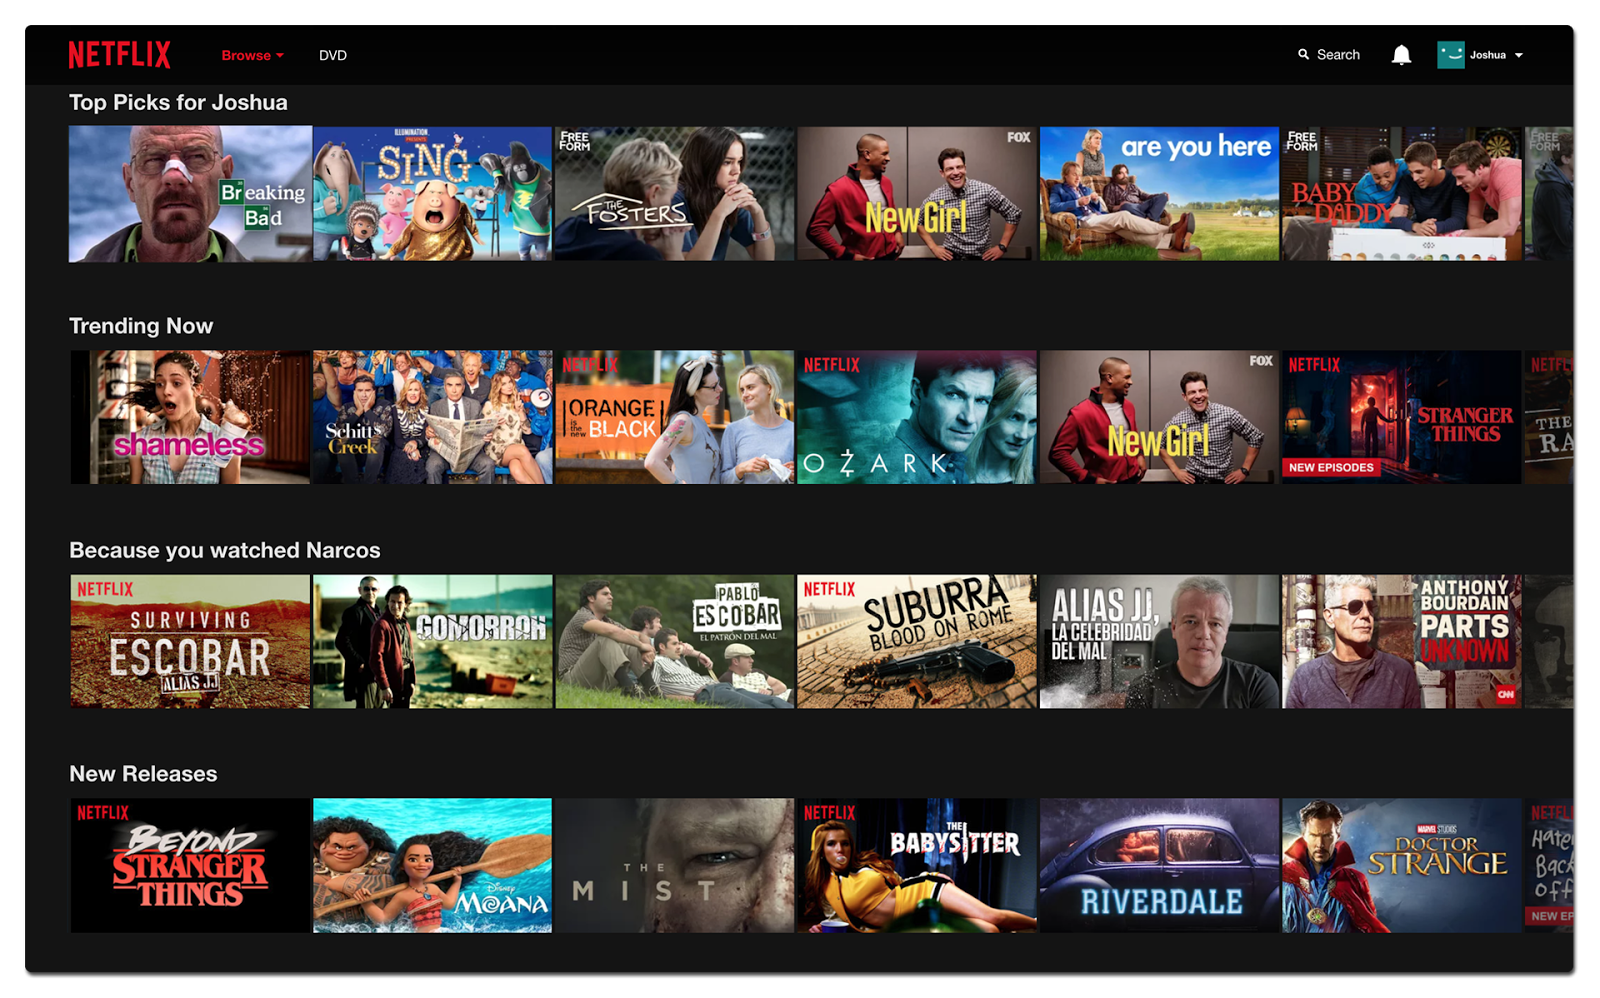

In [20]:
#Add netflix ka image
from IPython.display import Image
Image("netflix.png")
